<b>Exercise 2: NDVI</b>

1. Write a function that extracts from SentinelHub an image representing the NDVI of a
given location, instead of the RGB image.

<i><b>IMPORT SECTION</b></i>

In [15]:
%matplotlib inline
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import utils
import pandas as pd
import seaborn as sns
from matplotlib import cm
from shapely.geometry import Polygon
from sentinelhub.time_utils import parse_time

from sentinelhub import MimeType, SHConfig, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, \
    DataCollection, bbox_to_dimensions, DownloadRequest, FisRequest, Geometry, WcsRequest, HistogramType

<i><b>CONFIGURATION SECTION</b></i>

In [16]:
config = SHConfig()

config.instance_id = '14d0e021-6caf-4872-beab-b8b05921bdb6'
config.sh_client_id = 'e1a9bfc8-e283-4adf-971d-2c3d71787d9c'
config.sh_client_secret = 'B@DS2;sB8,k!qeGrXkxa?Rr3zC3bUt,M[a+7l5qf'

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub Process API, please provide the credentials (client ID and client secret).")

config.save()

<i><b>FUNCTIONS SECTION</b></i>

In [17]:
def square_from_point(center_longitude, center_latitude, side_length):
    from math import sqrt,atan,pi
    import pyproj
    
    square_coodrinate_points = {}
    geod = pyproj.Geod(ellps='WGS84')
    
    width = height = side_length#in meters
    diagonal = sqrt( width**2 + height**2 )

    #the azimuth is calculated by using the aspect ratio of the square.
    azimuth_1 = atan(width/height)
    azimuth_2 = atan(-width/height)
    azimuth_3 = atan(width/height)+pi #first point + 180 degrees
    azimuth_4 = atan(-width/height)+pi #second point + 180 degrees

    point_1_longitude, point_1_latitude, back_azimuth = geod.fwd(center_longitude, center_latitude, azimuth_1*180/pi, diagonal)
    point_2_longitude, point_2_latitude, back_azimuth = geod.fwd(center_longitude, center_latitude, azimuth_2*180/pi, diagonal)
    point_3_longitude, point_3_latitude, back_azimuth = geod.fwd(center_longitude, center_latitude, azimuth_3*180/pi, diagonal)
    point_4_longitude, point_4_latitude, back_azimuth = geod.fwd(center_longitude, center_latitude, azimuth_4*180/pi, diagonal)

    square_coodrinate_points = {
        'point_1_longitude': point_1_longitude,
        'point_1_latitude': point_1_latitude,
        'point_2_longitude': point_2_longitude,
        'point_2_latitude': point_2_latitude,
        'point_3_longitude': point_3_longitude,
        'point_3_latitude': point_3_latitude,
        'point_4_longitude': point_4_longitude,
        'point_4_latitude': point_4_latitude
    }
    
    return square_coodrinate_points 

def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    
def get_nvdi_request(time_interval, selected_bbox, selected_size):
    evalscript_true_color = """
        //VERSION=3
        function setup() {
          return{
            input: [{
              bands: ["B04", "B08"]
            }],
            output: {
              id: "default",
              bands: 1,
              sampleType: SampleType.FLOAT32
            }
          }
        }
        function evaluatePixel(sample) {
          let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04)
          return [ ndvi ];
          }
    """
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order='leastCC'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=selected_bbox,
        size=selected_size,
        config=config
    )

def get_fis_request(time_interval, selected_bbox):
    return FisRequest(
    data_collection=DataCollection.SENTINEL2_L1C,
    layer='NDVI',
    geometry_list=[selected_bbox],
    time=time_interval,
    resolution='60m',
    data_folder='./data',
    config=config
)

def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    """
    COLUMNS = ['channel', 'date', 'min', 'max', 'mean', 'stDev']
    data = []

    for fis_response in fis_data:
        for channel, channel_stats in fis_response.items():
            for stat in channel_stats:
                row = [int(channel[1:]), parse_time(stat['date'], force_datetime=True)]

                for column in COLUMNS[2:]:
                    row.append(stat['basicStats'][column])

                data.append(row)

    return pd.DataFrame(data, columns=COLUMNS).sort_values(['channel', 'date'])

<i><b>EXECUTION SECTION</b></i>

In [18]:
square_coodrinate_points = square_from_point(25.17186822071804, 43.649481644555074, 400)
bbox_coordinates_wgs84 = {
        'min_x':square_coodrinate_points["point_3_longitude"],
        'max_x':square_coodrinate_points["point_1_longitude"],
        'min_y':square_coodrinate_points["point_3_latitude"],
        'max_y':square_coodrinate_points["point_1_latitude"],
    }

In [20]:
resolution = 1
selected_bbox = BBox(bbox=bbox_coordinates_wgs84, crs=CRS.WGS84)
selected_size = bbox_to_dimensions(selected_bbox, resolution=resolution)

In [21]:
response = get_nvdi_request(('2020-06-01', '2020-06-30'), selected_bbox, selected_size)
nvdi_imgs = response.get_data()

Image type: float32


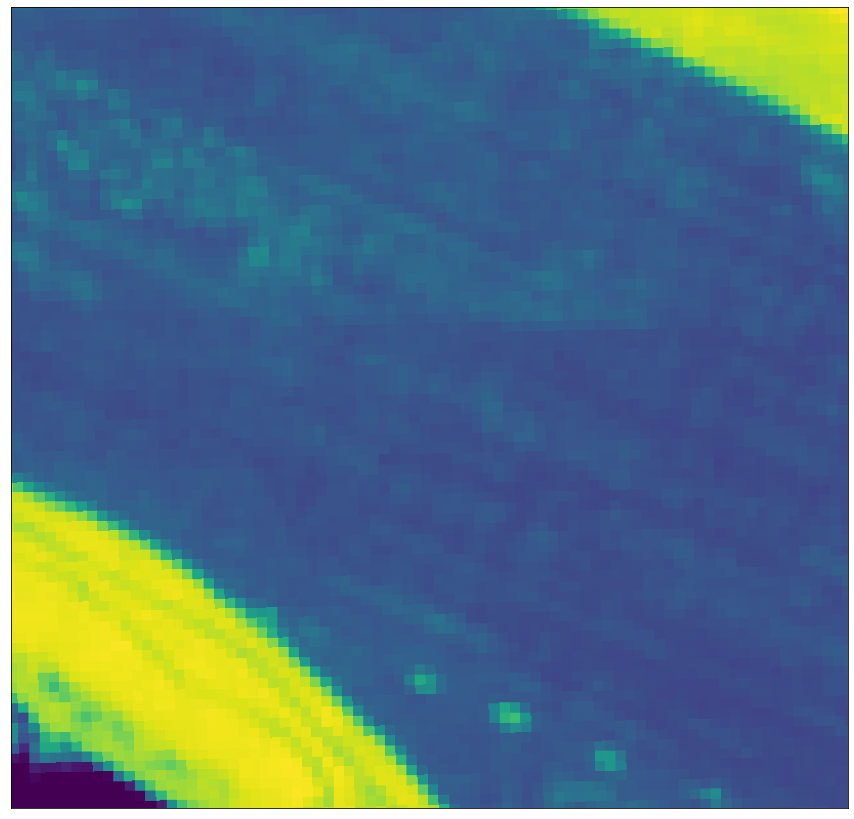

In [22]:
image = nvdi_imgs[0]
print(f'Image type: {image.dtype}')

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5/255, clip_range=(0,1))

2. Plot the evolution of the NDVI during a whole year in a time vs NDVI plot. Plot it for
different crops in the same figure to compare the evolution of the NDVI during the year
for different crop types (for example, corn, soybean and rapeseed). You can consider the
mean NDVI of the image as a representative value of the NDVI of the field.

In [23]:
response = get_fis_request(('2019-02-01', '2020-02-01'), selected_bbox)
fis_data = response.get_data(save_data=True)  # Takes about 30s, to avoid redownloading we are saving results
fis_data[0]['C0'][0]

In [24]:
df = fis_data_to_dataframe(fis_data)
df.head()

,channel,date,min,max,mean,stDev
142,0,2019-02-03,0.4,0.400000,0.400000,0.000000
141,0,2019-02-05,0.4,0.603922,0.560483,0.083494
140,0,2019-02-08,0.4,1.000000,0.416614,0.093471
139,0,2019-02-10,0.0,1.000000,0.982249,0.103967
138,0,2019-02-13,0.4,1.000000,0.407170,0.053075


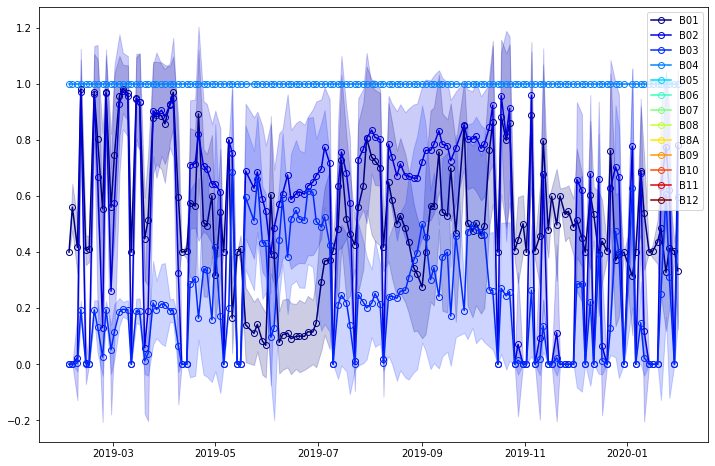

In [25]:
BANDS = 'B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12'.split(',')

plt.figure(figsize=(12, 8))
for channel, (band, color) in enumerate(zip(BANDS, cm.jet(np.linspace(0, 1, 13)))):
    channel_df = df[df.channel == channel]
    plt.plot(channel_df.date, channel_df['mean'], '-o', markeredgewidth=1,
             color=color, markerfacecolor='None', label=band)
    plt.fill_between(list(channel_df.date),  channel_df['mean'] - channel_df['stDev'],
                     channel_df['mean'] + channel_df['stDev'], alpha=0.2, color=color)

plt.legend(loc='upper right');